In [33]:
# ==========================================
# DATA DOWNLOAD
# ==========================================
!pip install kagglehub
import kagglehub, os

# Download dataset from Kaggle
path = kagglehub.dataset_download("raghadalharbi/breast-cancer-gene-expression-profiles-metabric")


In [34]:
# Install all required packages 
!pip install lifelines scikit-survival pandas numpy matplotlib seaborn scikit-learn

In [35]:
# ==========================================
# 0. SETUP
# ==========================================

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test

# Machine learning (for later)
from sklearn.model_selection import train_test_split

# Settings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.1.4
NumPy version: 1.26.4


In [36]:
# ==========================================
# 1. DATA LOADING & INITIAL EXPLORATION
# ==========================================

# Load data
df = pd.read_csv(os.path.join(path, 'METABRIC_RNA_Mutation.csv')) 
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
display(df.head())


DATASET OVERVIEW

Shape: 1904 rows × 693 columns

First 5 rows:


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,...,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Show all column names
cols = df.columns.tolist()
print(f"\nTotal columns: {len(cols)}\n")
for i in range(0, min(50, len(cols)), 5):  # Show first 50
    print(f"{i:3d}-{i+4:3d}: {', '.join(cols[i:i+5])}")

print("\n... (showing first 50 of 693 columns)")


Total columns: 693

  0-  4: patient_id, age_at_diagnosis, type_of_breast_surgery, cancer_type, cancer_type_detailed
  5-  9: cellularity, chemotherapy, pam50_+_claudin-low_subtype, cohort, er_status_measured_by_ihc
 10- 14: er_status, neoplasm_histologic_grade, her2_status_measured_by_snp6, her2_status, tumor_other_histologic_subtype
 15- 19: hormone_therapy, inferred_menopausal_state, integrative_cluster, primary_tumor_laterality, lymph_nodes_examined_positive
 20- 24: mutation_count, nottingham_prognostic_index, oncotree_code, overall_survival_months, overall_survival
 25- 29: pr_status, radio_therapy, 3-gene_classifier_subtype, tumor_size, tumor_stage
 30- 34: death_from_cancer, brca1, brca2, palb2, pten
 35- 39: tp53, atm, cdh1, chek2, nbn
 40- 44: nf1, stk11, bard1, mlh1, msh2
 45- 49: msh6, pms2, epcam, rad51c, rad51d

... (showing first 50 of 693 columns)


In [38]:
# Find survival columns
print("\n" + "="*60)
print("SURVIVAL-RELATED COLUMNS")
print("="*60)

survival_keywords = ['survival', 'time', 'status', 'event', 'death', 
                    'vital', 'os', 'follow', 'months', 'days']

survival_cols = [col for col in df.columns 
                if any(keyword in col.lower() for keyword in survival_keywords)]

for col in survival_cols:
    print(f"\n{col}:")
    print(f"  Type: {df[col].dtype}")
    print(f"  Missing: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.1f}%)")
    
    if df[col].dtype in ['int64', 'float64']:
        print(f"  Range: {df[col].min():.1f} to {df[col].max():.1f}")
        print(f"  Mean: {df[col].mean():.1f}")
    else:
        print(f"  Unique values: {df[col].unique()[:10]}")


SURVIVAL-RELATED COLUMNS

age_at_diagnosis:
  Type: float64
  Missing: 0 (0.0%)
  Range: 21.9 to 96.3
  Mean: 61.1

er_status_measured_by_ihc:
  Type: object
  Missing: 30 (1.6%)
  Unique values: ['Positve' 'Negative' nan]

er_status:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['Positive' 'Negative']

her2_status_measured_by_snp6:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['NEUTRAL' 'LOSS' 'GAIN' 'UNDEF']

her2_status:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['Negative' 'Positive']

lymph_nodes_examined_positive:
  Type: float64
  Missing: 0 (0.0%)
  Range: 0.0 to 45.0
  Mean: 2.0

nottingham_prognostic_index:
  Type: float64
  Missing: 0 (0.0%)
  Range: 1.0 to 6.4
  Mean: 4.0

overall_survival_months:
  Type: float64
  Missing: 0 (0.0%)
  Range: 0.0 to 355.2
  Mean: 125.1

overall_survival:
  Type: int64
  Missing: 0 (0.0%)
  Range: 0.0 to 1.0
  Mean: 0.4

pr_status:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['Negative' 'Positive']

death_from

In [39]:
# Search for clinical columns
print("\n" + "="*60)
print("CLINICAL COLUMNS")
print("="*60)

clinical_keywords = ['age', 'stage', 'grade', 'er', 'pr', 'her2', 
                    'tumor', 'receptor', 'type', 'subtype', 'patient']

clinical_cols = [col for col in df.columns 
                if any(keyword in col.lower() for keyword in clinical_keywords)]

print(f"Found {len(clinical_cols)} potential clinical variables:\n")
for col in clinical_cols[:15]:  # Show first 15
    print(f"{col}:")
    print(f"  Type: {df[col].dtype}")
    
    if df[col].dtype == 'object':
        print(f"  Values: {df[col].value_counts().head(5).to_dict()}")
    else:
        print(f"  Range: {df[col].min():.1f} to {df[col].max():.1f}")
    print()


CLINICAL COLUMNS
Found 65 potential clinical variables:

patient_id:
  Type: int64
  Range: 0.0 to 7299.0

age_at_diagnosis:
  Type: float64
  Range: 21.9 to 96.3

type_of_breast_surgery:
  Type: object
  Values: {'MASTECTOMY': 1127, 'BREAST CONSERVING': 755}

cancer_type:
  Type: object
  Values: {'Breast Cancer': 1903, 'Breast Sarcoma': 1}

cancer_type_detailed:
  Type: object
  Values: {'Breast Invasive Ductal Carcinoma': 1500, 'Breast Mixed Ductal and Lobular Carcinoma': 207, 'Breast Invasive Lobular Carcinoma': 142, 'Breast Invasive Mixed Mucinous Carcinoma': 22, 'Breast': 17}

chemotherapy:
  Type: int64
  Range: 0.0 to 1.0

pam50_+_claudin-low_subtype:
  Type: object
  Values: {'LumA': 679, 'LumB': 461, 'Her2': 220, 'claudin-low': 199, 'Basal': 199}

er_status_measured_by_ihc:
  Type: object
  Values: {'Positve': 1445, 'Negative': 429}

er_status:
  Type: object
  Values: {'Positive': 1459, 'Negative': 445}

neoplasm_histologic_grade:
  Type: float64
  Range: 1.0 to 3.0

her2_s

In [40]:
# Count gene expression columns
print("\n" + "="*60)
print("GENE EXPRESSION COLUMNS")
print("="*60)

# Genes are likely anything NOT clinical or survival
exclude_keywords = ['patient', 'age', 'stage', 'grade', 'er', 'pr', 'her2',
                   'survival', 'status', 'type', 'cohort', 'tumor', 'death']

potential_genes = [col for col in df.columns 
                  if not any(keyword in col.lower() for keyword in exclude_keywords)]

print(f"Potential gene expression columns: {len(potential_genes)}")
print(f"\nFirst 20 examples:")
for i, gene in enumerate(potential_genes[:20]):
    print(f"  {gene}")


GENE EXPRESSION COLUMNS
Potential gene expression columns: 627

First 20 examples:
  cellularity
  lymph_nodes_examined_positive
  mutation_count
  oncotree_code
  brca1
  brca2
  palb2
  pten
  tp53
  atm
  cdh1
  chek2
  nbn
  nf1
  stk11
  bard1
  mlh1
  msh2
  msh6
  pms2


In [41]:
# ==========================================
# 2. DATA PREPARATION
# ==========================================

print("="*60)
print("DATA CLEANING & VARIABLE SELECTION")
print("="*60)

# Create working dataset
df_clean = df.copy()

# Standardize survival variables
df_clean['time'] = df_clean['overall_survival_months']
df_clean['event'] = df_clean['overall_survival']  # Already 0/1

# Basic quality checks
print(f"\nOriginal dataset: {len(df)} patients")
print(f"Survival time range: {df_clean['time'].min():.1f} to {df_clean['time'].max():.1f} months")
print(f"Events: {df_clean['event'].sum()} ({df_clean['event'].mean():.1%})")
print(f"Censored: {(1-df_clean['event']).sum()} ({(1-df_clean['event']).mean():.1%})")

DATA CLEANING & VARIABLE SELECTION

Original dataset: 1904 patients
Survival time range: 0.0 to 355.2 months
Events: 801 (42.1%)
Censored: 1103 (57.9%)


In [42]:
# Apply inclusion/exclusion criteria
print("\n" + "="*60)
print("APPLYING INCLUSION/EXCLUSION CRITERIA")
print("="*60)

# Remove patients with invalid survival data
n_before = len(df_clean)

# Remove zero or negative survival times
df_clean = df_clean[df_clean['time'] > 0]
print(f"Removed {n_before - len(df_clean)} patients with time ≤ 0")

# Remove missing survival data (shouldn't be any, but check)
n_before = len(df_clean)
df_clean = df_clean[df_clean['time'].notna() & df_clean['event'].notna()]
print(f"Removed {n_before - len(df_clean)} patients with missing survival data")

print(f"\n✓ Final analytic cohort: {len(df_clean)} patients")
print(f"  Events: {df_clean['event'].sum()} ({df_clean['event'].mean():.1%})")
print(f"  Median follow-up: {df_clean['time'].median():.1f} months")


APPLYING INCLUSION/EXCLUSION CRITERIA
Removed 1 patients with time ≤ 0
Removed 0 patients with missing survival data

✓ Final analytic cohort: 1903 patients
  Events: 800 (42.0%)
  Median follow-up: 115.6 months


In [43]:
# Define clinical variables
print("\n" + "="*60)
print("CLINICAL VARIABLES")
print("="*60)

clinical_cols = [
    'age_at_diagnosis',
    'er_status',
    'pr_status', 
    'her2_status',
    'neoplasm_histologic_grade',
    'lymph_nodes_examined_positive'
]

print(f"Selected {len(clinical_cols)} clinical variables:")
for col in clinical_cols:
    missing = df_clean[col].isnull().sum()
    missing_pct = missing / len(df_clean) * 100
    print(f"  {col}: {missing} missing ({missing_pct:.1f}%)")
    
    if df_clean[col].dtype == 'object':
        print(f"    Distribution: {df_clean[col].value_counts().to_dict()}")
    else:
        print(f"    Mean ± SD: {df_clean[col].mean():.1f} ± {df_clean[col].std():.1f}")


CLINICAL VARIABLES
Selected 6 clinical variables:
  age_at_diagnosis: 0 missing (0.0%)
    Mean ± SD: 61.1 ± 13.0
  er_status: 0 missing (0.0%)
    Distribution: {'Positive': 1459, 'Negative': 444}
  pr_status: 0 missing (0.0%)
    Distribution: {'Positive': 1009, 'Negative': 894}
  her2_status: 0 missing (0.0%)
    Distribution: {'Negative': 1667, 'Positive': 236}
  neoplasm_histologic_grade: 71 missing (3.7%)
    Mean ± SD: 2.4 ± 0.7
  lymph_nodes_examined_positive: 0 missing (0.0%)
    Mean ± SD: 2.0 ± 4.1


In [44]:
# Define gene expression variables
print("\n" + "="*60)
print("GENE EXPRESSION VARIABLES")
print("="*60)

# Identify gene columns (exclude clinical/administrative variables)
exclude_cols = ['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
                'cancer_type', 'cancer_type_detailed', 'cellularity',
                'chemotherapy', 'pam50_+_claudin-low_subtype',
                'cohort', 'er_status_measured_by_ihc', 'er_status',
                'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
                'her2_status', 'tumor_other_histologic_subtype',
                'hormone_therapy', 'inferred_menopausal_state',
                'integrative_cluster', 'lymph_nodes_examined_positive',
                'mutation_count', 'nottingham_prognostic_index',
                'oncotree_code', 'overall_survival_months', 'overall_survival',
                'pr_status', 'primary_tumor_laterality', 'radio_therapy',
                'tumor_size', 'tumor_stage', 'death_from_cancer',
                'time', 'event']

# Gene columns are everything else
gene_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Identified {len(gene_cols)} gene expression features")
print(f"\nFirst 20 genes: {gene_cols[:20]}")
print(f"Last 20 genes: {gene_cols[-20:]}")

# Check for missing data in genes
gene_missing = df_clean[gene_cols].isnull().sum()
genes_with_missing = gene_missing[gene_missing > 0]

if len(genes_with_missing) > 0:
    print(f"\n{len(genes_with_missing)} genes have missing data:")
    print(genes_with_missing.head(10))
else:
    print("\n✓ No missing data in gene expression features")


GENE EXPRESSION VARIABLES
Identified 663 gene expression features

First 20 genes: ['3-gene_classifier_subtype', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d']
Last 20 genes: ['tbl1xr1_mut', 'frmd3_mut', 'smad2_mut', 'sgcd_mut', 'spaca1_mut', 'rasgef1b_mut', 'hist1h2bc_mut', 'nr2f1_mut', 'klrg1_mut', 'mbl2_mut', 'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut']

1 genes have missing data:
3-gene_classifier_subtype    204
dtype: int64


In [45]:
# Handle missing data
print("\n" + "="*60)
print("MISSING DATA HANDLING")
print("="*60)

# For genes: median imputation if < 10% missing
if len(genes_with_missing) > 0:
    print("Imputing gene expression missing values with median...")
    for gene in genes_with_missing.index:
        missing_pct = genes_with_missing[gene] / len(df_clean)
        if missing_pct < 0.10:
            df_clean[gene].fillna(df_clean[gene].median(), inplace=True)
        else:
            print(f"  Warning: {gene} has {missing_pct:.1%} missing - consider excluding")

# For clinical variables: will handle in Cox model (complete case)
clinical_missing = df_clean[clinical_cols].isnull().sum()
print(f"\nClinical variables missing data:")
print(clinical_missing[clinical_missing > 0])


MISSING DATA HANDLING
Imputing gene expression missing values with median...

Clinical variables missing data:
neoplasm_histologic_grade    71
dtype: int64


In [46]:
# ==========================================
# MISSING DATA DECISIONS
# ==========================================

print("\n" + "="*60)
print("MISSING DATA DECISIONS")
print("="*60)

# Decision 1: Exclude gene with >10% missing
gene_to_exclude = '3-gene_classifier_subtype'
if gene_to_exclude in gene_cols:
    gene_cols.remove(gene_to_exclude)
    print(f"✓ Excluded {gene_to_exclude} (10.7% missing)")

print(f"Final gene count: {len(gene_cols)} genes")

# Decision 2: Tumor grade missing
grade_missing = df_clean['neoplasm_histologic_grade'].isnull().sum()
grade_missing_pct = grade_missing / len(df_clean) * 100

print(f"\nTumor grade missing: {grade_missing} ({grade_missing_pct:.1f}%)")
print("Decision: Use complete case analysis for Cox models")
print("(Patients with missing grade will be excluded from clinical model)")

# Check how many patients we'll lose
cox_complete = df_clean[clinical_cols + ['time', 'event']].dropna()
print(f"\nPatients with complete clinical data: {len(cox_complete)} / {len(df_clean)}")
print(f"Lost to missing: {len(df_clean) - len(cox_complete)} ({(len(df_clean) - len(cox_complete))/len(df_clean)*100:.1f}%)")


MISSING DATA DECISIONS
✓ Excluded 3-gene_classifier_subtype (10.7% missing)
Final gene count: 662 genes

Tumor grade missing: 71 (3.7%)
Decision: Use complete case analysis for Cox models
(Patients with missing grade will be excluded from clinical model)

Patients with complete clinical data: 1832 / 1903
Lost to missing: 71 (3.7%)


In [47]:
# Summary of final dataset
print("\n" + "="*60)
print("FINAL ANALYTIC DATASET SUMMARY")
print("="*60)

print(f"Total patients: {len(cox_complete)}")
print(f"Events (deaths): {cox_complete['event'].sum()}")
print(f"Censored: {(1-cox_complete['event']).sum()}")
print(f"Follow-up time: {cox_complete['time'].median():.1f} months (median)")
print(f"\nFeature counts:")
print(f"  Clinical variables: {len(clinical_cols)}")
print(f"  Gene expression: {len(gene_cols)}")
print(f"  Total features: {len(clinical_cols) + len(gene_cols)}")

# Save the cleaned dataset info
print(f"\n✓ Data preparation complete")


FINAL ANALYTIC DATASET SUMMARY
Total patients: 1832
Events (deaths): 779
Censored: 1053
Follow-up time: 114.8 months (median)

Feature counts:
  Clinical variables: 6
  Gene expression: 662
  Total features: 668

✓ Data preparation complete


In [48]:
# ==========================================
# 3. KAPLAN-MEIER SURVIVAL ANALYSIS
# ==========================================

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

print("="*60)
print("KAPLAN-MEIER SURVIVAL CURVES")
print("="*60)

KAPLAN-MEIER SURVIVAL CURVES


In [49]:

os.makedirs('figures', exist_ok=True)


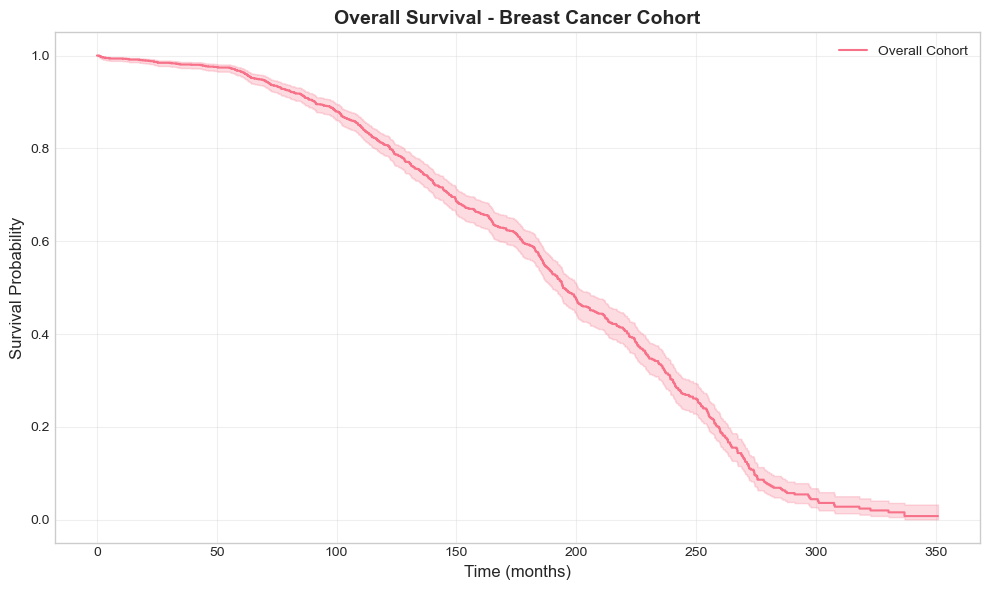


=== Overall Survival Statistics ===
Median survival: 194.6 months
5-year survival probability: 96.57%
95% CI for 5-year survival: [95.48%, 97.29%]


In [50]:
# Fit overall KM curve
kmf = KaplanMeierFitter()
kmf.fit(durations=cox_complete['time'], 
        event_observed=cox_complete['event'],
        label='Overall Cohort')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
kmf.plot_survival_function(ax=ax, ci_show=True)
plt.title('Overall Survival - Breast Cancer Cohort', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/km_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
median_survival = kmf.median_survival_time_
survival_5yr = kmf.predict(60) 

print(f"\n=== Overall Survival Statistics ===")
print(f"Median survival: {median_survival:.1f} months")
print(f"5-year survival probability: {survival_5yr:.2%}")
print(f"95% CI for 5-year survival: [{kmf.confidence_interval_survival_function_.iloc[kmf.timeline.searchsorted(60), 0]:.2%}, "
      f"{kmf.confidence_interval_survival_function_.iloc[kmf.timeline.searchsorted(60), 1]:.2%}]")


SURVIVAL BY ER STATUS


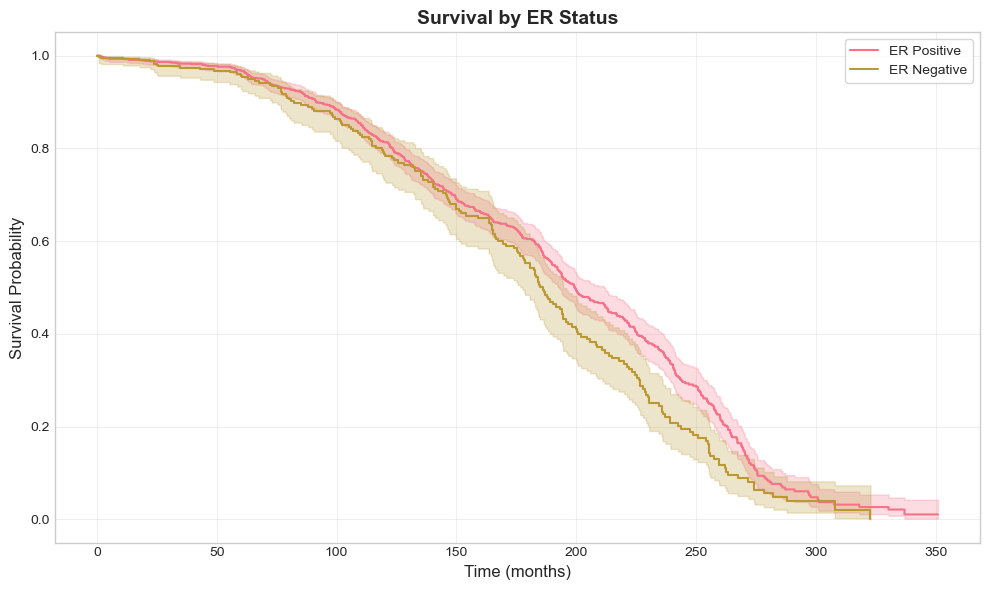


ER Positive (n=1396): Median survival = 150.5 months
ER Negative (n=436): Median survival = 170.2 months

Log-rank test:
  Test statistic: 7.13
  P-value: 0.0076
  ✓ Significant difference in survival by ER status


In [51]:
# Stratified KM curve by ER status
print("\n" + "="*60)
print("SURVIVAL BY ER STATUS")
print("="*60)

fig, ax = plt.subplots(figsize=(10, 6))

# ER positive
er_pos = cox_complete[cox_complete['er_status'] == 'Positive']
kmf.fit(durations=er_pos['time'], 
        event_observed=er_pos['event'],
        label='ER Positive')
kmf.plot_survival_function(ax=ax, ci_show=True)

# ER negative
er_neg = cox_complete[cox_complete['er_status'] == 'Negative']
kmf.fit(durations=er_neg['time'], 
        event_observed=er_neg['event'],
        label='ER Negative')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Survival by ER Status', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('figures/km_by_er_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
results = logrank_test(
    durations_A=er_pos['time'],
    durations_B=er_neg['time'],
    event_observed_A=er_pos['event'],
    event_observed_B=er_neg['event']
)

print(f"\nER Positive (n={len(er_pos)}): Median survival = {er_pos['time'][er_pos['event']==1].median():.1f} months")
print(f"ER Negative (n={len(er_neg)}): Median survival = {er_neg['time'][er_neg['event']==1].median():.1f} months")
print(f"\nLog-rank test:")
print(f"  Test statistic: {results.test_statistic:.2f}")
print(f"  P-value: {results.p_value:.4f}")

if results.p_value < 0.05:
    print(f"  ✓ Significant difference in survival by ER status")
else:
    print(f"  No significant difference in survival by ER status")


SURVIVAL BY HER2 STATUS


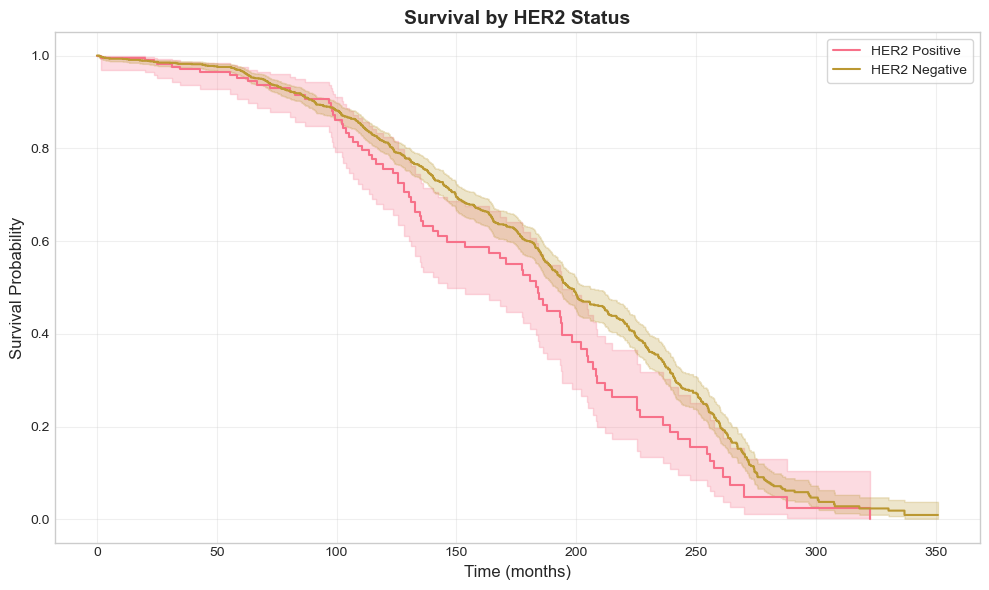


HER2 Positive (n=229): Median survival = 138.3 months
HER2 Negative (n=1603): Median survival = 158.0 months

Log-rank test p-value: 0.0075
  ✓ Significant difference in survival by HER2 status


In [52]:
# Stratified KM curve by HER2 status
print("\n" + "="*60)
print("SURVIVAL BY HER2 STATUS")
print("="*60)

fig, ax = plt.subplots(figsize=(10, 6))

# HER2 positive
her2_pos = cox_complete[cox_complete['her2_status'] == 'Positive']
kmf.fit(durations=her2_pos['time'], 
        event_observed=her2_pos['event'],
        label='HER2 Positive')
kmf.plot_survival_function(ax=ax, ci_show=True)

# HER2 negative
her2_neg = cox_complete[cox_complete['her2_status'] == 'Negative']
kmf.fit(durations=her2_neg['time'], 
        event_observed=her2_neg['event'],
        label='HER2 Negative')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Survival by HER2 Status', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('figures/km_by_her2_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
results_her2 = logrank_test(
    durations_A=her2_pos['time'],
    durations_B=her2_neg['time'],
    event_observed_A=her2_pos['event'],
    event_observed_B=her2_neg['event']
)

print(f"\nHER2 Positive (n={len(her2_pos)}): Median survival = {her2_pos['time'][her2_pos['event']==1].median():.1f} months")
print(f"HER2 Negative (n={len(her2_neg)}): Median survival = {her2_neg['time'][her2_neg['event']==1].median():.1f} months")
print(f"\nLog-rank test p-value: {results_her2.p_value:.4f}")
if results_her2.p_value < 0.05:
    print(f"  ✓ Significant difference in survival by HER2 status")
else:
    print(f"  No significant difference in survival by HER2 status")


SURVIVAL BY TUMOR GRADE


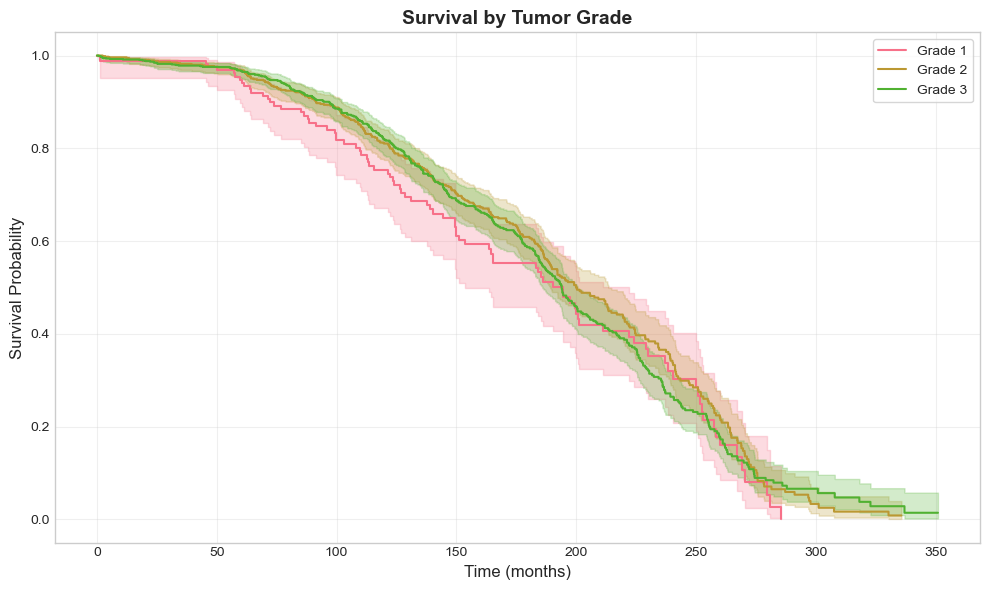


Sample sizes by grade:
neoplasm_histologic_grade
1.0    165
2.0    740
3.0    927
Name: count, dtype: int64


In [53]:
# Stratified KM curve by tumor grade
print("\n" + "="*60)
print("SURVIVAL BY TUMOR GRADE")
print("="*60)

fig, ax = plt.subplots(figsize=(10, 6))

grades = sorted(cox_complete['neoplasm_histologic_grade'].unique())
for grade in grades:
    grade_subset = cox_complete[cox_complete['neoplasm_histologic_grade'] == grade]
    kmf.fit(durations=grade_subset['time'], 
            event_observed=grade_subset['event'],
            label=f'Grade {int(grade)}')
    kmf.plot_survival_function(ax=ax, ci_show=True) 

plt.title('Survival by Tumor Grade', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('figures/km_by_grade.png', dpi=300, bbox_inches='tight')
plt.show()

# Sample sizes by grade
print("\nSample sizes by grade:")
print(cox_complete['neoplasm_histologic_grade'].value_counts().sort_index())